In this notebook I follow the Tensor Flow tutorial https://www.tensorflow.org/tutorials/structured_data/imbalanced_data on skewed data sets, applying it to a stroke prediction dataset.

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [6]:
file = tf.keras.utils
raw_df = pd.read_csv('D:\carse\Datasets\healthcare-dataset-stroke-data.csv')
raw_df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
neg, pos = np.bincount(raw_df['stroke'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 5110
    Positive: 249 (4.87% of total)



In [10]:
cleaned_df = raw_df.copy()
cleaned_df.pop('id')
cleaned_df = cleaned_df.dropna()

In [12]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
min_max_cols = ['age', 'avg_glucose_level', 'bmi']


In [14]:
for col in categorical_cols:
    cleaned_df[col] = pd.Categorical(cleaned_df[col])
    cleaned_df[col] = cleaned_df[col].cat.codes

cleaned_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,1,81.0,0,0,1,2,1,186.21,29.0,1,1


In [16]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('stroke'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('stroke'))
test_labels = np.array(test_df.pop('stroke'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [18]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (3141,)
Validation labels shape: (786,)
Test labels shape: (982,)
Training features shape: (3141, 10)
Validation features shape: (786, 10)
Test features shape: (982, 10)


c:\Users\carse\Documents\dev\ml-notebooks\ml-notebooks-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\carse\Documents\dev\ml-notebooks\ml-notebooks-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


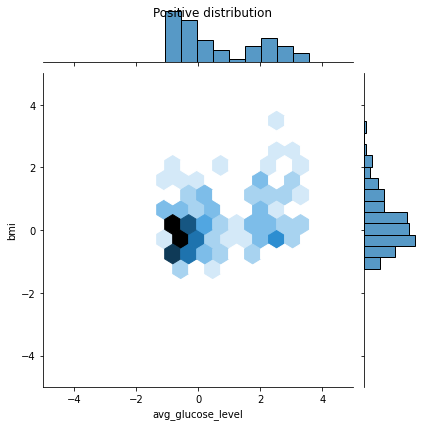

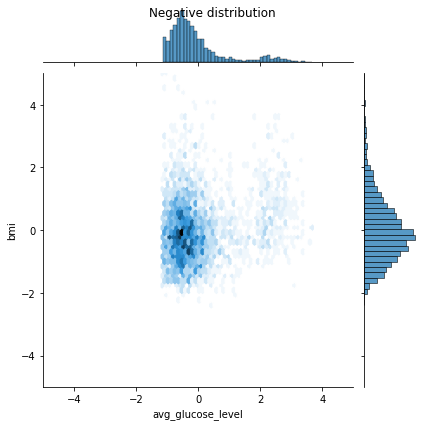

In [20]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['avg_glucose_level'], pos_df['bmi'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['avg_glucose_level'], neg_df['bmi'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")


In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [24]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [26]:
model = make_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                176       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.predict(train_features[:10])


array([[0.8722292 ],
       [0.8661244 ],
       [0.9066069 ],
       [0.89803004],
       [0.8516447 ],
       [0.8576355 ],
       [0.7673286 ],
       [0.9448378 ],
       [0.82168233],
       [0.7968148 ]], dtype=float32)

In [30]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 2.1656


In [32]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.97154656])

In [34]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])


array([[0.0153698 ],
       [0.01499319],
       [0.05858994],
       [0.03347775],
       [0.05842736],
       [0.01736253],
       [0.01413459],
       [0.01824522],
       [0.03824592],
       [0.10053134]], dtype=float32)

In [36]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.1620


In [38]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


In [40]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [42]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [44]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


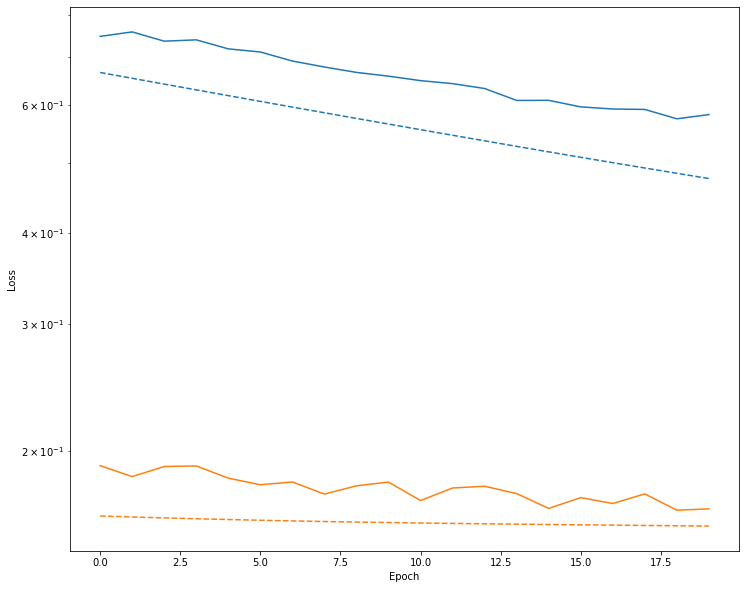

In [46]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


In [48]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))


Epoch 1/100
2/2 [==============================] - 2s 553ms/step - loss: 0.1876 - tp: 15.3333 - fp: 63.0000 - tn: 3348.6667 - fn: 135.6667 - accuracy: 0.9443 - precision: 0.2003 - recall: 0.1024 - auc: 0.7256 - prc: 0.1290 - val_loss: 0.1630 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 753.0000 - val_fn: 33.0000 - val_accuracy: 0.9580 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7403 - val_prc: 0.1157
Epoch 2/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1789 - tp: 13.6667 - fp: 53.6667 - tn: 2608.0000 - fn: 101.3333 - accuracy: 0.9445 - precision: 0.2078 - recall: 0.1235 - auc: 0.7174 - prc: 0.1358 - val_loss: 0.1625 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 753.0000 - val_fn: 33.0000 - val_accuracy: 0.9580 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7381 - val_prc: 0.1200
Epoch 3/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1855 - tp: 14.3333 - fp: 52.0000 - tn: 2609.6667 - fn: 100.66

In [50]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


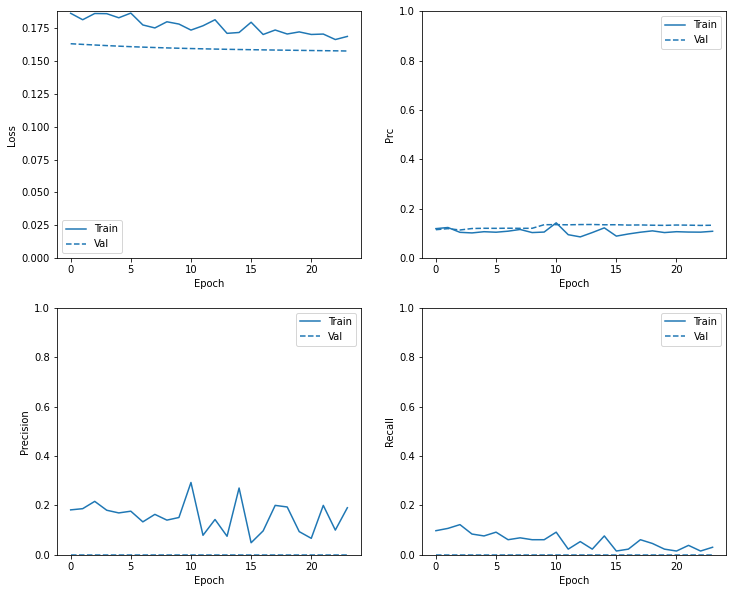

In [52]:
plot_metrics(baseline_history)

In [54]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


In [56]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Stroke Correctly Detected (True Negatives): ', cm[0][0])
  print('Stroke Incorrectly Detected (False Positives): ', cm[0][1])
  print('Stroke Missed (False Negatives): ', cm[1][0])
  print('Strokes Correctly Detected (True Positives): ', cm[1][1])
  print('Total Strokes: ', np.sum(cm[1]))


loss :  0.17115813493728638
tp :  0.0
fp :  0.0
tn :  937.0
fn :  45.0
accuracy :  0.9541751742362976
precision :  0.0
recall :  0.0
auc :  0.7644729614257812
prc :  0.11264908313751221

No Stroke Correctly Detected (True Negatives):  937
Stroke Incorrectly Detected (False Positives):  0
Stroke Missed (False Negatives):  45
Strokes Correctly Detected (True Positives):  0
Total Strokes:  45


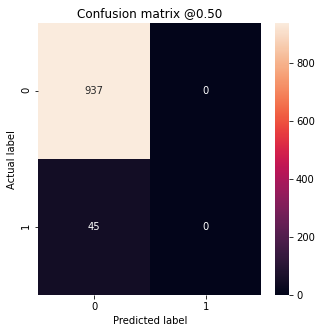

In [58]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


In [60]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


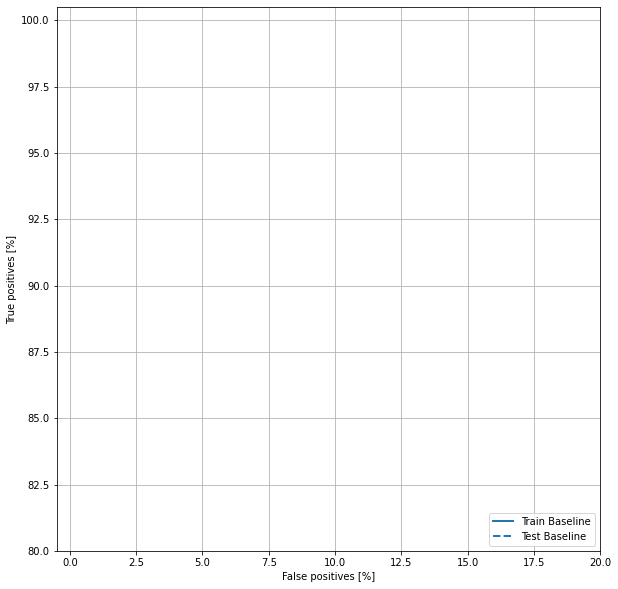

In [62]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')


In [64]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


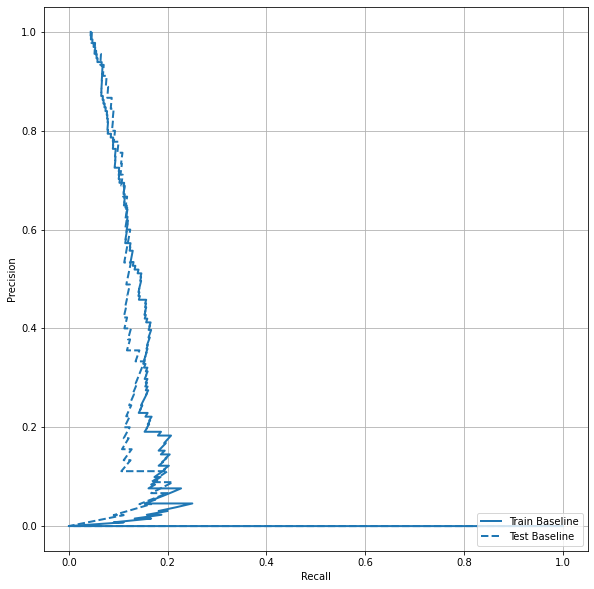

In [66]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')


In [68]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.53
Weight for class 1: 10.26


In [70]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


Epoch 1/100
2/2 [==============================] - 2s 564ms/step - loss: 1.1681 - tp: 11.6667 - fp: 89.0000 - tn: 3322.6667 - fn: 139.3333 - accuracy: 0.9357 - precision: 0.1154 - recall: 0.0768 - auc: 0.6837 - prc: 0.0932 - val_loss: 0.1639 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 752.0000 - val_fn: 32.0000 - val_accuracy: 0.9580 - val_precision: 0.5000 - val_recall: 0.0303 - val_auc: 0.7470 - val_prc: 0.1157
Epoch 2/100
2/2 [==============================] - 0s 13ms/step - loss: 1.0513 - tp: 9.3333 - fp: 74.3333 - tn: 2588.6667 - fn: 104.3333 - accuracy: 0.9358 - precision: 0.1098 - recall: 0.0813 - auc: 0.6935 - prc: 0.1006 - val_loss: 0.1643 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 752.0000 - val_fn: 32.0000 - val_accuracy: 0.9580 - val_precision: 0.5000 - val_recall: 0.0303 - val_auc: 0.7446 - val_prc: 0.1158
Epoch 3/100
2/2 [==============================] - 0s 13ms/step - loss: 1.0585 - tp: 10.3333 - fp: 73.6667 - tn: 2588.3333 - fn: 104.3333 - accuracy: 0.9362 - precision

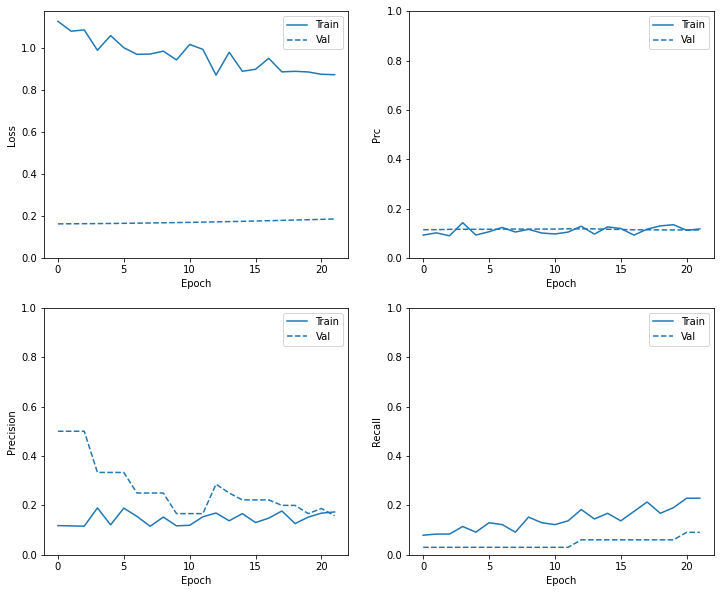

In [72]:
plot_metrics(weighted_history)


In [74]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)


loss :  0.190477654337883
tp :  1.0
fp :  15.0
tn :  922.0
fn :  44.0
accuracy :  0.9399185180664062
precision :  0.0625
recall :  0.02222222276031971
auc :  0.7868137359619141
prc :  0.12558960914611816

No Stroke Correctly Detected (True Negatives):  922
Stroke Incorrectly Detected (False Positives):  15
Stroke Missed (False Negatives):  44
Strokes Correctly Detected (True Positives):  1
Total Strokes:  45


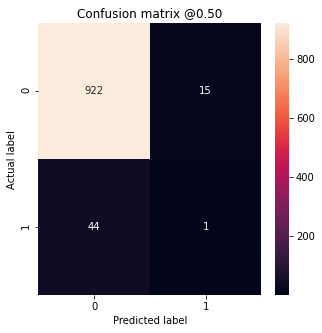

In [76]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)


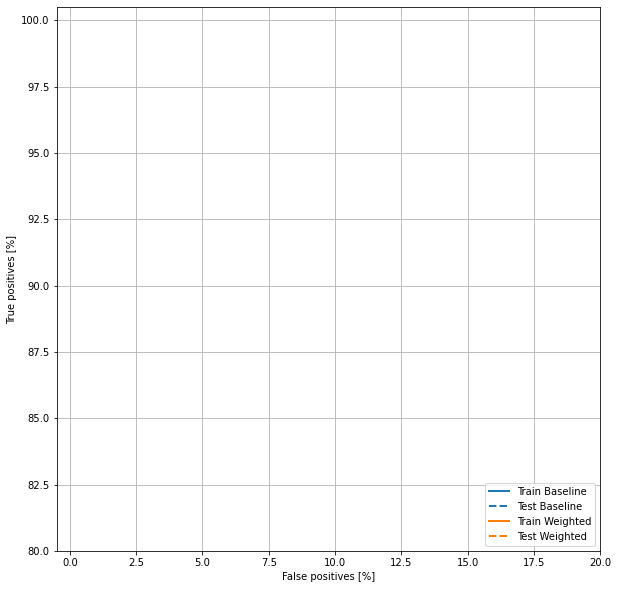

In [78]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')


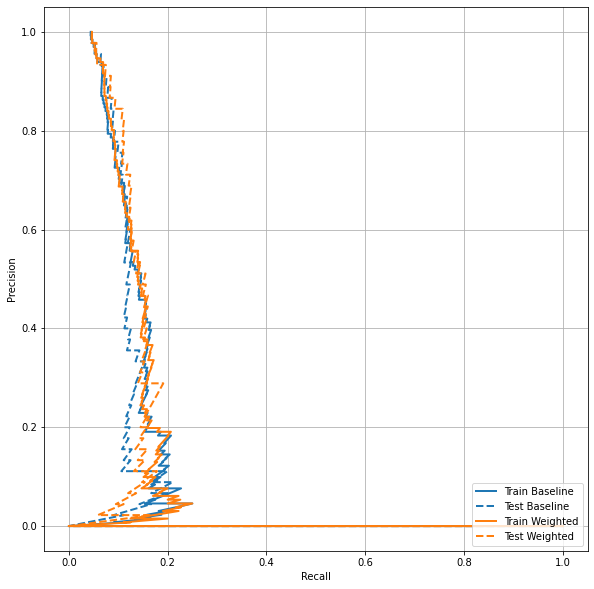

In [80]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')


In [82]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


In [84]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(3010, 10)

In [86]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(6020, 10)

In [88]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [90]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())


Features:
 [-0.8206204   0.99166433 -0.3231569  -0.22472577  0.72644596 -0.16404152
 -1.03863169 -0.10626455 -0.11861562 -0.3458481 ]

Label:  1


In [92]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)


In [94]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())


0.49853515625


In [96]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

5.0

In [98]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)


Epoch 1/100
5/5 [==============================] - 2s 144ms/step - loss: 0.6751 - tp: 2407.3333 - fp: 1634.5000 - tn: 2584.6667 - fn: 986.1667 - accuracy: 0.6570 - precision: 0.5852 - recall: 0.7055 - auc: 0.7233 - prc: 0.6577 - val_loss: 0.6667 - val_tp: 24.0000 - val_fp: 271.0000 - val_tn: 482.0000 - val_fn: 9.0000 - val_accuracy: 0.6438 - val_precision: 0.0814 - val_recall: 0.7273 - val_auc: 0.7499 - val_prc: 0.1218
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6571 - tp: 2374.3333 - fp: 1392.8333 - tn: 2092.6667 - fn: 966.8333 - accuracy: 0.6530 - precision: 0.6291 - recall: 0.7084 - auc: 0.7130 - prc: 0.6963 - val_loss: 0.6557 - val_tp: 24.0000 - val_fp: 268.0000 - val_tn: 485.0000 - val_fn: 9.0000 - val_accuracy: 0.6476 - val_precision: 0.0822 - val_recall: 0.7273 - val_auc: 0.7557 - val_prc: 0.1224
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.6513 - tp: 2417.3333 - fp: 1335.1667 - tn: 2037.8333 - fn: 1036.3333 - accuracy: 0.

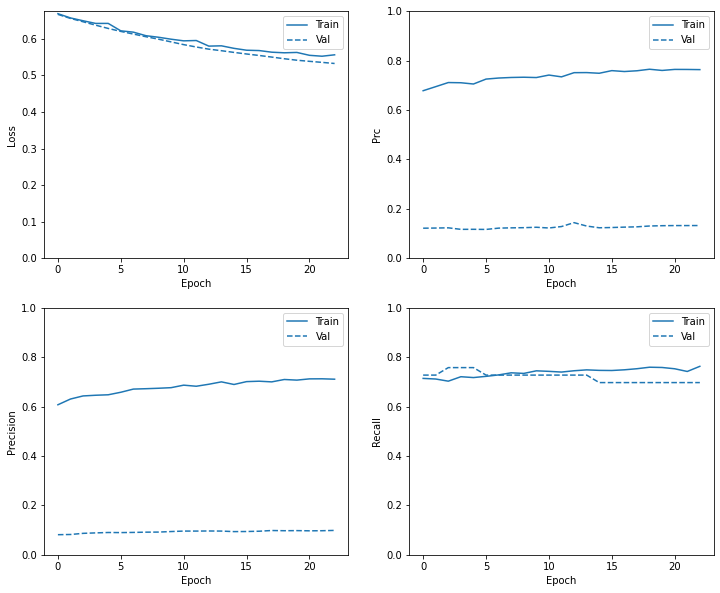

In [100]:
plot_metrics(resampled_history)


In [102]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))


Epoch 1/1000
20/20 [==============================] - 2s 37ms/step - loss: 0.6625 - tp: 8042.3810 - fp: 4717.0952 - tn: 7197.4286 - fn: 3259.5714 - accuracy: 0.6568 - precision: 0.6207 - recall: 0.7101 - auc: 0.7225 - prc: 0.6921 - val_loss: 0.6411 - val_tp: 25.0000 - val_fp: 261.0000 - val_tn: 492.0000 - val_fn: 8.0000 - val_accuracy: 0.6578 - val_precision: 0.0874 - val_recall: 0.7576 - val_auc: 0.7646 - val_prc: 0.1228
Epoch 2/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.6315 - tp: 8135.5238 - fp: 4241.2381 - tn: 7010.7619 - fn: 3042.9524 - accuracy: 0.6733 - precision: 0.6550 - recall: 0.7276 - auc: 0.7341 - prc: 0.7148 - val_loss: 0.6046 - val_tp: 24.0000 - val_fp: 237.0000 - val_tn: 516.0000 - val_fn: 9.0000 - val_accuracy: 0.6870 - val_precision: 0.0920 - val_recall: 0.7273 - val_auc: 0.7728 - val_prc: 0.1172
Epoch 3/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.6016 - tp: 8205.3810 - fp: 3961.1429 - tn: 7338.4286 - fn: 2925.5238 - ac

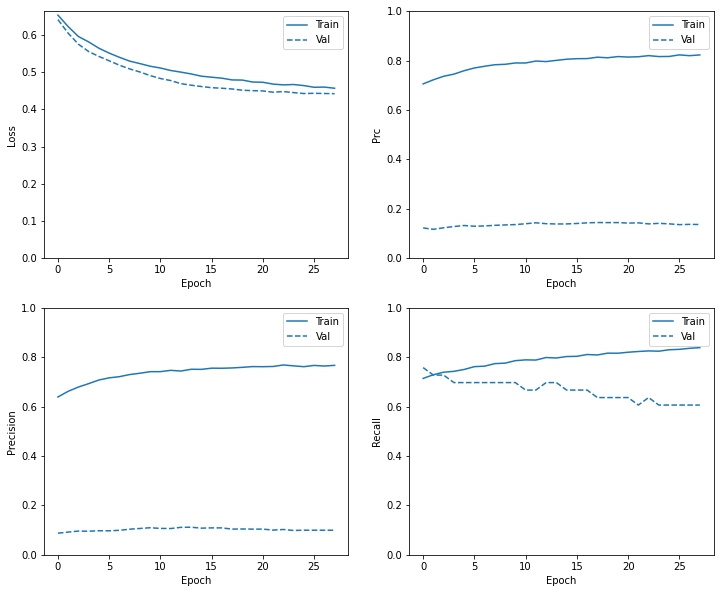

In [104]:
plot_metrics(resampled_history)


In [106]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)


loss :  0.4919048845767975
tp :  37.0
fp :  273.0
tn :  664.0
fn :  8.0
accuracy :  0.7138493061065674
precision :  0.11935483664274216
recall :  0.8222222328186035
auc :  0.8302976489067078
prc :  0.19641020894050598

No Stroke Correctly Detected (True Negatives):  664
Stroke Incorrectly Detected (False Positives):  273
Stroke Missed (False Negatives):  8
Strokes Correctly Detected (True Positives):  37
Total Strokes:  45


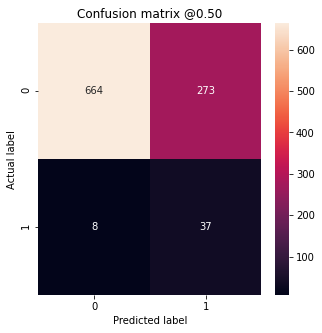

In [108]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)
